In [1]:
# Installo le librerie che mi servono
!pip install -qq ultralytics fiftyone opencv-python

## 2) Import delle librerie

In [2]:
# Import delle librerie
import os
import random
import cv2
import matplotlib.pyplot as plt
import fiftyone as fo
import fiftyone.zoo as foz
from ultralytics import YOLO

print("Librerie importate!")

Librerie importate!


## 3) Download dataset con FiftyOne
Scarico le immagini da OpenImages per le 5 classi di animali.

In [3]:
# Le classi che voglio
classi = ["Horse", "Lizard", "Mouse", "Hamster", "Mule"]

print("Inizio download...")
print("Classi:", classi)

Inizio download...
Classi: ['Horse', 'Lizard', 'Mouse', 'Hamster', 'Mule']


In [4]:
# Scarico il dataset da OpenImages
dataset = foz.load_zoo_dataset(
    "open-images-v7",
    split="train",
    label_types=["detections"],
    classes=classi,
    max_samples=500,
    seed=42,
    shuffle=True
)

print("Dataset scaricato!")
print("Numero immagini:", len(dataset))

INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/open-images-v7/train' if necessary


Necessary images already downloaded


INFO:fiftyone.utils.openimages:Necessary images already downloaded


Existing download of split 'train' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'train' is sufficient


Loading 'open-images-v7' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'train'


 100% |█████████████████| 500/500 [2.8s elapsed, 0s remaining, 176.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 500/500 [2.8s elapsed, 0s remaining, 176.7 samples/s]      


Dataset 'open-images-v7-train-500' created


INFO:fiftyone.zoo.datasets:Dataset 'open-images-v7-train-500' created


Dataset scaricato!
Numero immagini: 500


In [5]:
print(dataset.count_values("ground_truth.detections.label"))

{'Tree': 194, 'Man': 133, 'Window': 20, 'Cowboy hat': 9, 'Bicycle wheel': 1, 'Fedora': 2, 'Palm tree': 2, 'Human eye': 1, 'Suit': 9, 'Fruit': 1, 'Human nose': 8, 'Human head': 32, 'Vehicle': 6, 'Poster': 1, 'Footwear': 82, 'Squirrel': 2, 'Wheel': 51, 'Street light': 2, 'Chair': 2, 'Clothing': 231, 'Barrel': 1, 'Sculpture': 26, 'Bull': 1, 'Bowl': 1, 'Dog': 1, 'Cat': 1, 'Table': 1, 'Mouse': 50, 'Building': 10, 'Person': 499, 'Boy': 8, 'Fashion accessory': 18, 'Flower': 18, 'Car': 24, 'Cart': 27, 'Rabbit': 2, 'Bronze sculpture': 8, 'Sword': 1, 'Auto part': 2, 'House': 17, 'Dress': 4, 'Apple': 3, 'Frog': 2, 'Fountain': 3, 'Cattle': 28, 'Jeans': 2, 'Sun hat': 12, 'Hat': 4, 'Flag': 8, 'Plant': 182, 'Human mouth': 3, 'Boot': 1, 'Hamster': 26, 'Toy': 14, 'Helmet': 12, 'Sports equipment': 6, 'Horse': 667, 'Human body': 9, 'Swimwear': 1, 'Mule': 69, 'Tire': 16, 'Human face': 66, 'Bench': 1, 'Human arm': 9, 'Human leg': 17, 'Human hand': 4, 'Trombone': 54, 'Girl': 9, 'Umbrella': 1, 'Mammal': 1, '

In [6]:
print("Immagini totali dataset:", len(dataset))


Immagini totali dataset: 500


In [7]:
# Il dataset è già filtrato da FiftyOne (immagini già con annotazioni delle classi richieste)
dataset_filtrato = dataset.clone()   # CREO un dataset persistente per poter applicare tag

print("Immagini dopo filtraggio:", len(dataset_filtrato))


Immagini dopo filtraggio: 500


In [8]:
# Conto quante immagini ho per ogni classe
print("\nImmagini per classe:")
for classe in classi:
    num = len(dataset_filtrato.filter_labels("ground_truth", fo.ViewField("label") == classe))
    print(f"{classe}: {num}")


Immagini per classe:
Horse: 355
Lizard: 84
Mouse: 38
Hamster: 21
Mule: 33


In [9]:
# Divido il dataset in train/val/test
# 70% train, 15% val, 15% test

tot = len(dataset_filtrato)
n_train = int(tot * 0.7)
n_val = int(tot * 0.15)
n_test = tot - n_train - n_val

print(f"\nTrain: {n_train}")
print(f"Val: {n_val}")
print(f"Test: {n_test}")


Train: 350
Val: 75
Test: 75


In [10]:
# Prendo gli ID delle immagini e li mescolo
tutti_id = dataset_filtrato.values("id")
random.seed(42)
random.shuffle(tutti_id)

# Divido gli ID
train_ids = tutti_id[:n_train]
val_ids = tutti_id[n_train:n_train+n_val]
test_ids = tutti_id[n_train+n_val:]

print("ID divisi!")

ID divisi!


In [11]:
list_tag = ["train", "val", "test"]

for tag in list_tag:
    dataset_filtrato.untag_samples(tag)

dataset_filtrato.select(train_ids).tag_samples("train")
dataset_filtrato.select(val_ids).tag_samples("val")
dataset_filtrato.select(test_ids).tag_samples("test")

print("Tag assegnati:")
print("Train:", len(dataset_filtrato.match_tags("train")))
print("Val:", len(dataset_filtrato.match_tags("val")))
print("Test:", len(dataset_filtrato.match_tags("test")))

Tag assegnati:
Train: 350
Val: 75
Test: 75


In [27]:
!ls -R /content/dataset_yolo # export_dir="/content/dataset_yolo/train"


/content/dataset_yolo:
data.yaml  test  train	val

/content/dataset_yolo/test:
dataset.yaml  images  labels

/content/dataset_yolo/test/images:
val

/content/dataset_yolo/test/images/val:
00703988ba97cc5b.jpg  35ffe7d48d99e6d1.jpg  896aeac9f9a14dbb.jpg
007e15b67e8a602c.jpg  3d55d9da541e1c73.jpg  8d23510027a43ed8.jpg
00b7d61016ec9b94.jpg  45cb50fa8b1d97a7.jpg  8fcb993816d9bbc1.jpg
029b0a89fb954813.jpg  47ab56f3966f61de.jpg  903289a5d0d4d2e1.jpg
036458302c430453.jpg  48dedf416308ec14.jpg  9a985edf6873b848.jpg
048275db68e56e12.jpg  4ca64f33155be525.jpg  9bb82c55897758a0.jpg
057e966f5eff9d60.jpg  4debfeddd67e78dc.jpg  9bfeecfef844e839.jpg
0763ec75aab4b46e.jpg  4ff56dcddf3532ad.jpg  9e94ffbb7ee782a0.jpg
0891fe602db686af.jpg  5258516e9eebe2eb.jpg  9f2b8311ab006e09.jpg
08baf4134c773f7b.jpg  56e817845e9ba84b.jpg  a11f7569a7b0d753.jpg
0a662b4f161a1ef0.jpg  57de7e41b029d9be.jpg  a4b0ded0dbec8058.jpg
0c2eb37222a78797.jpg  597e2ab24dc75cb6.jpg  aae1cff91a69b74c.jpg
0e39b3bd6eb8e3e8.jpg  60824d978c

In [12]:
# Conto quante immagini del TEST set hanno ogni classe
test_view = dataset_filtrato.match_tags("test")

print("IMMAGINI PER CLASSE NEL TEST SET:")
for classe in classi:
    n = len(test_view.filter_labels("ground_truth", fo.ViewField("label") == classe))
    print(f"- {classe}: {n} immagini")


IMMAGINI PER CLASSE NEL TEST SET:
- Horse: 54 immagini
- Lizard: 13 immagini
- Mouse: 3 immagini
- Hamster: 1 immagini
- Mule: 8 immagini


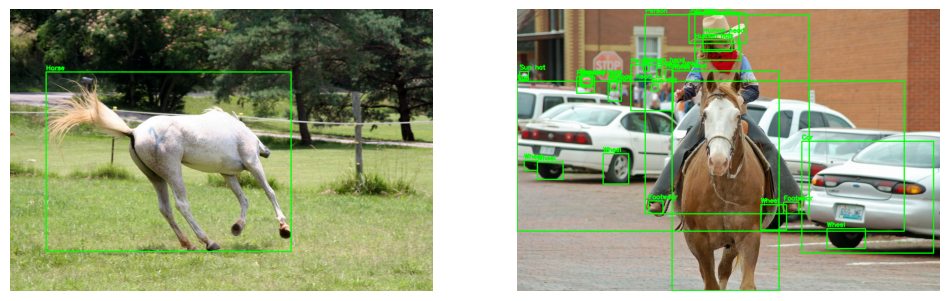

In [13]:
# Mostro 2 immagini di esempio
train_samples = dataset_filtrato.match_tags("train")
sample_list = list(train_samples.take(2))

img1 = cv2.imread(sample_list[0].filepath)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
h1, w1 = img1.shape[:2]

for det in sample_list[0].ground_truth.detections:
    bbox = det.bounding_box
    x = int(bbox[0] * w1)
    y = int(bbox[1] * h1)
    w_box = int(bbox[2] * w1)
    h_box = int(bbox[3] * h1)
    cv2.rectangle(img1, (x, y), (x+w_box, y+h_box), (0, 255, 0), 2)
    cv2.putText(img1, det.label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

img2 = cv2.imread(sample_list[1].filepath)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
h2, w2 = img2.shape[:2]

for det in sample_list[1].ground_truth.detections:
    bbox = det.bounding_box
    x = int(bbox[0] * w2)
    y = int(bbox[1] * h2)
    w_box = int(bbox[2] * w2)
    h_box = int(bbox[3] * h2)
    cv2.rectangle(img2, (x, y), (x+w_box, y+h_box), (0, 255, 0), 2)
    cv2.putText(img2, det.label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img1)
ax[0].axis('off')
ax[1].imshow(img2)
ax[1].axis('off')
plt.show()

## 4) Esportazione in formato YOLO

In [14]:
# Esporto in formato YOLO — PRIMA CANCELLO TUTTO PER EVITARE CARTELLE SPORCHE
export_path = "/content/dataset_yolo"

!rm -rf /content/dataset_yolo

print("Esporto train...")
train_view = dataset_filtrato.match_tags("train")
train_view.export(
    export_dir=export_path + "/train",
    dataset_type=fo.types.YOLOv5Dataset,
    label_field="ground_truth",
    classes=classi
)

print("Esporto val...")
val_view = dataset_filtrato.match_tags("val")
val_view.export(
    export_dir=export_path + "/val",
    dataset_type=fo.types.YOLOv5Dataset,
    label_field="ground_truth",
    classes=classi
)

print("Esporto test...")
test_view = dataset_filtrato.match_tags("test")
test_view.export(
    export_dir=export_path + "/test",
    dataset_type=fo.types.YOLOv5Dataset,
    label_field="ground_truth",
    classes=classi
)

print("Tutto esportato!")

Esporto train...
  11% |█/---------------|  38/350 [110.3ms elapsed, 905.8ms remaining, 344.5 samples/s] 

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Man' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Footwear' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Person' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Tree' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Clothing' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Girl' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12

  41% |██████|----------| 142/350 [420.3ms elapsed, 615.7ms remaining, 337.8 samples/s] 

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Bicycle wheel' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Cowboy hat' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Fedora' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Human body' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Human head' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Human arm' not in provided classes
  warnings.warn(msg)


  63% |██████████-------| 221/350 [631.8ms elapsed, 368.8ms remaining, 349.8 samples/s] 

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Bull' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Mammal' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Building' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Vehicle' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Dog' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Street light' not in provided classes
  warnings.warn(msg)


  81% |█████████████|---| 285/350 [836.2ms elapsed, 190.7ms remaining, 340.8 samples/s] 

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Rabbit' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Window' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Fountain' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Truck' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Palm tree' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Umbrella' not in provided classes
  warnings.warn(msg)


 100% |█████████████████| 350/350 [1.0s elapsed, 0s remaining, 344.4 samples/s]         


/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Cat' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Boot' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Dress' not in provided classes
  warnings.warn(msg)
INFO:eta.core.utils: 100% |█████████████████| 350/350 [1.0s elapsed, 0s remaining, 344.4 samples/s]         


Esporto val...
   0% ||------------------|  0/75 [5.6ms elapsed, ? remaining, ? samples/s] 

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Auto part' not in provided classes
  warnings.warn(msg)


 100% |███████████████████| 75/75 [209.5ms elapsed, 0s remaining, 357.9 samples/s]      


/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Apple' not in provided classes
  warnings.warn(msg)
INFO:eta.core.utils: 100% |███████████████████| 75/75 [209.5ms elapsed, 0s remaining, 357.9 samples/s]      


Esporto test...
   0% ||------------------|  0/75 [3.3ms elapsed, ? remaining, ? samples/s] 

/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Swimwear' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Sports equipment' not in provided classes
  warnings.warn(msg)


 100% |███████████████████| 75/75 [187.6ms elapsed, 0s remaining, 399.8 samples/s]     


/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Bowl' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Sword' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/fiftyone/utils/yolo.py:1030: UserWarning: Ignoring object with label 'Frog' not in provided classes
  warnings.warn(msg)
INFO:eta.core.utils: 100% |███████████████████| 75/75 [187.6ms elapsed, 0s remaining, 399.8 samples/s]     


Tutto esportato!


In [15]:
# Controllo struttura cartelle
!tree -L 3 /content/dataset_yolo

/bin/bash: line 1: tree: command not found


In [16]:
# Creo il file data.yaml per YOLO
yaml_content = f"""path: {export_path}
train: train/images
val: val/images
test: test/images

nc: {len(classi)}
names: {classi}
"""

yaml_file = export_path + "/data.yaml"
with open(yaml_file, 'w') as f:
    f.write(yaml_content)

print("File data.yaml creato!")
print(yaml_content)

File data.yaml creato!
path: /content/dataset_yolo
train: train/images
val: val/images
test: test/images

nc: 5
names: ['Horse', 'Lizard', 'Mouse', 'Hamster', 'Mule']



## 5) Caricamento modello YOLO

In [17]:
model = YOLO("yolo11s.pt")
print("Modello caricato!")

Modello caricato!


## 6) Training

In [18]:
epoche = 15
img_size = 640
batch = 16

print(f"Inizio training con {epoche} epoche...")

Inizio training con 15 epoche...


In [19]:
risultati = model.train(
    data=yaml_file,
    epochs=epoche,
    imgsz=img_size,
    batch=batch,
    project="/content/yolo_train",
    name="animali",
    seed=42
) # max 20 min

print("Training finito!")

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset_yolo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=animali2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0,

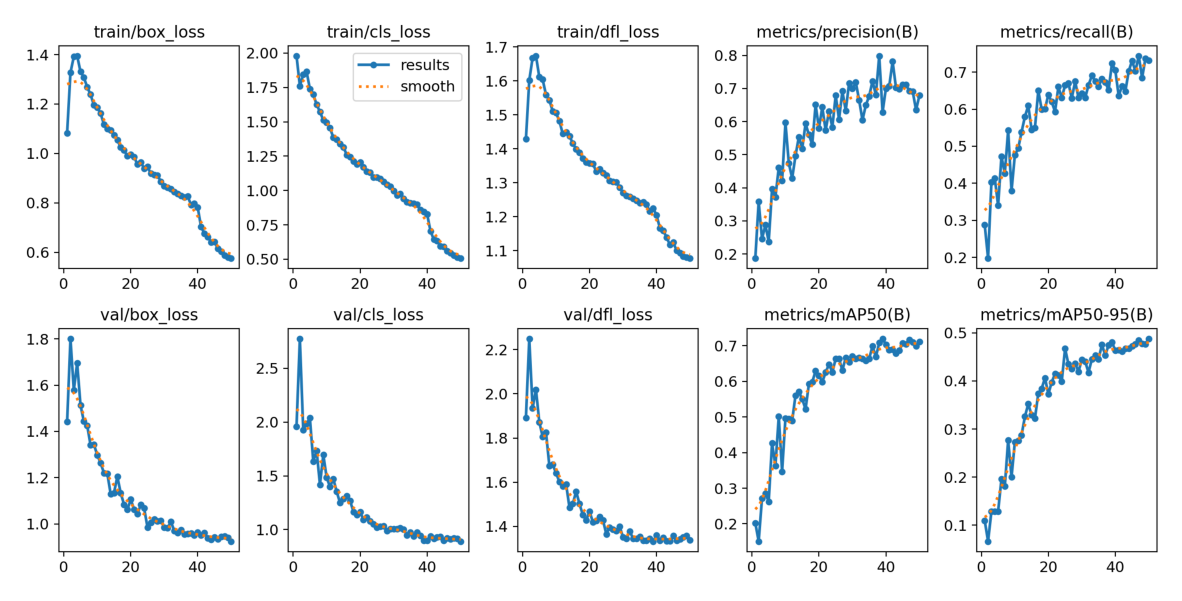

In [20]:
img_risultati = "/content/yolo_train/animali/results.png"

img = plt.imread(img_risultati)
plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [21]:
best_model = YOLO("/content/yolo_train/animali/weights/best.pt")
print("Modello migliore caricato!")

Modello migliore caricato!


## 7) Valutazione sul test set

In [22]:
print("Valuto sul test set...")
metriche = best_model.val(data=export_path + "/data.yaml", split="test")

print("\nRISULTATI TEST SET")
print("="*40)
print(f"mAP@0.5: {metriche.box.map50}")
print(f"mAP@0.5:0.95: {metriche.box.map}")
print(f"Precision: {metriche.box.mp}")
print(f"Recall: {metriche.box.mr}")

Valuto sul test set...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11s summary (fused): 100 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2445.7±566.2 MB/s, size: 238.1 KB)
val: Scanning /content/dataset_yolo/test/labels/val... 75 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 75/75 1.5Kit/s 0.1s
val: New cache created: /content/dataset_yolo/test/labels/val.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 3.6it/s 1.4s
                   all         75        124      0.732      0.825      0.844      0.665
                 Horse         54         83      0.894      0.952      0.964      0.841
                Lizard         13         19      0.836      0.895      0.965      0.669
                 Mouse          3          4      0.764       0.75       0.87      0.737
               Hamster          1

In [25]:
# Quante immagini nel test contengono almeno 1 detection?
test_view = dataset_filtrato.match_tags("test")

count_con_bbox = 0

for s in test_view:
    if s.ground_truth and len(s.ground_truth.detections) > 0:
        count_con_bbox += 1

print("Immagini nel test set:", len(test_view))
print("Immagini con almeno 1 bounding box:", count_con_bbox)


Immagini nel test set: 75
Immagini con almeno 1 bounding box: 75


## 8) Inferenza sul test set

In [24]:
# Cartella test YOLO
test_img_folder = "/content/dataset_yolo/test/images"
test_lbl_folder = "/content/dataset_yolo/test/labels"

# Lista delle immagini esportate da YOLO
test_imgs = sorted([
    f for f in os.listdir(test_img_folder)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
])

print("Immagini esportate nel test:", len(test_imgs))

# Vista dei sample del test nell'oggetto FiftyOne
test_view = dataset_filtrato.match_tags("test")

img_da_testare = []
classi_trovate = []

print("\nCerco 1 immagine per ogni classe:")
for classe in classi:
    # Prendo la prima immagine del test che contiene quella classe
    samples_classe = test_view.filter_labels("ground_truth", fo.ViewField("label") == classe)

    if len(samples_classe) > 0:
        sample = samples_classe.first()

        # Nome del file originale
        original_name = os.path.splitext(os.path.basename(sample.filepath))[0]

        # Cerco il file corrispondente tra le immagini YOLO
        # Gli export YOLO rinominano i file in ordine, quindi cerco per matching parziale
        img_name = None
        for f in test_imgs:
            if original_name in f:
                img_name = f
                break

        # Se non lo trovo, prendo un'immagine qualsiasi del test
        if img_name is None:
            img_name = test_imgs[0]

        img_da_testare.append(img_name)
        classi_trovate.append(classe)
        print(f"  {classe}: {img_name}")

    else:
        print(f"  {classe}: NON trovata nel test set")

print("\nImmagini selezionate:", img_da_testare)


# Inferenza
predizioni = []
print("\nEseguo inferenza...")
for img_name in img_da_testare:
    img_path = os.path.join(test_img_folder, img_name)
    pred = best_model(img_path)[0]
    predizioni.append(pred)

print("Inferenza completata!")

Immagini esportate nel test: 0

Cerco 1 immagine per ogni classe:


IndexError: list index out of range

In [ ]:
# Mostro le immagini con le predizioni
print(f"\nMostro {len(img_da_testare)} immagini (1 per classe):\n")

for i in range(len(img_da_testare)):
    img_path = os.path.join(test_img_folder, img_da_testare[i])
    classe_gt = classi_trovate[i]

    print(f"Immagine {i+1}: {img_da_testare[i]}")
    print(f"  Ground Truth: {classe_gt}")

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    pred = predizioni[i]
    boxes = pred.boxes

    print(f"  Numero predizioni: {len(boxes)}")

    for j, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
        conf = float(box.conf)
        cls = int(box.cls)
        label = classi[cls]

        print(f"    Box {j+1}: {label} conf={conf:.2f}")

        cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 3)
        cv2.putText(img, f"{label} {conf:.2f}", (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,0,0), 3)

    plt.figure(figsize=(10,8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print()

## 9) BONUS - Modello HuggingFace

In [ ]:
!pip install transformers

In [ ]:
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import torch

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
detr = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

device = "cuda" if torch.cuda.is_available() else "cpu"
detr = detr.to(device)

print(f"DETR caricato su {device}!")

In [ ]:
print("DETR riconosce solo Horse e Mouse (sono nel dataset COCO)")

In [ ]:
img_per_detr = img_da_testare[:3]
detr_preds = []

for img_name in img_per_detr:
    img_path = os.path.join(test_img_folder, img_name)
    image = Image.open(img_path)

    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = detr(**inputs)

    target_sizes = torch.tensor([image.size[::-1]]).to(device)
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

    detr_preds.append(results)

print("Inferenza DETR completata!")

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    img_path = os.path.join(test_img_folder, img_per_detr[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = detr_preds[i]

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = box.cpu().numpy()
        x1, y1, x2, y2 = map(int, box)
        label_name = detr.config.id2label[label.item()]

        cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
        cv2.putText(img, f"{label_name} {score:.2f}", (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"DETR {i+1}")

plt.tight_layout()
plt.show()

## 10) Conclusione

In [ ]:
print("\nCONFRONTO YOLO vs DETR")
print("="*40)
print("\nYOLO (fine-tuned):")
print("  - Riconosce tutte e 5 le classi")
print("  - mAP@0.5 sul test:", metriche.box.map50)
print("  - Veloce")
print("\nDETR (pre-trained su COCO):")
print("  - Riconosce solo Horse e Mouse")
print("  - Non addestrato sulle nostre classi")
print("  - Piu lento")